# Lotka-Volterra

How efficient are the solvers on a simple benchmark problem?

In [1]:
from functools import partial

import jax
import jax.experimental.ode
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scipy.integrate
from _benchmark_utils import plot_config, print_info, workprecision
from diffeqzoo import backend, ivps
from jax import config

from odefilter import controls, ivpsolve, solvers
from odefilter.implementations import dense, isotropic
from odefilter.strategies import filters

# x64 precision
config.update("jax_enable_x64", True)

# CPU
config.update("jax_platform_name", "cpu")

# IVP examples in JAX
if not backend.has_been_selected:
    backend.select("jax")

# Nice-looking plots
plt.rcParams.update(plot_config())

# Which version of the softwares are we using?
print_info()

odefilter version:
	0.0.1a2.dev4+dirty
Most recent commit:
	b'9f6727\n'

jax:    0.3.23
jaxlib: 0.3.22
numpy:  1.23.4
python: 3.8.10 (default, Jun 22 2022, 20:18:18)  [GCC 9.4.0]
jax.devices (1 total, 1 local): [CpuDevice(id=0)]
process_count: 1

$ nvidia-smi
Wed Nov  2 10:35:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVS 510             Off  | 00000000:4B:00.0 N/A |                  N/A |
| 32%   59C    P0    N/A /  N/A |    976MiB /  1998MiB |     N/A    

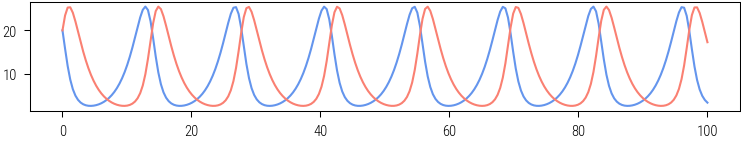

In [2]:
# Make a problem
f, u0, (t0, t1), f_args = ivps.lotka_volterra(time_span=(0.0, 100.0))
ODE_NAME = "Lotka-Volterra"


@jax.jit
def vf(x, *, t, p):
    return f(x, *p)


@jax.jit
def vf_jax(u, t, *p):
    return vf(u, t=t, p=p)


@jax.jit
def vf_scipy(t, u, *p):
    return vf(u, t=t, p=p)


vf_scipy_jac = jax.jit(jax.jacfwd(vf_scipy, argnums=1))

# Compile
vf(u0, t=t0, p=f_args)
vf_jax(u0, t0, *f_args)
vf_scipy(t0, u0, *f_args)
vf_scipy_jac(t0, u0, *f_args)

ts = jnp.linspace(t0, t1, num=250)
scipy_solution = scipy.integrate.solve_ivp(
    vf_scipy,
    y0=u0,
    t_span=(t0, t1),
    args=f_args,
    t_eval=ts,
    atol=2.23 * 1e-14,
    rtol=2.23 * 1e-14,
    method="LSODA",  # LSODA because it is not a competitor
    jac=vf_scipy_jac,
)
ys_reference = scipy_solution.y.T[-1, :]

fig, ax = plt.subplots(figsize=(5, 1))
ax.plot(ts, scipy_solution.y.T, marker="None")
plt.show()

In [3]:
def solver_to_solve(solver):
    return jax.jit(partial(_solve, solver=solver))


def _solve(*, solver, tol):
    solution = ivpsolve.simulate_terminal_values(
        vf,
        initial_values=(u0,),
        t0=t0,
        t1=t1,
        parameters=f_args,
        solver=solver,
        atol=1e-3 * tol,
        rtol=tol,
        control=controls.ProportionalIntegral(),
    )
    diff = (solution.u - ys_reference) / (1e-5 + ys_reference)
    return jnp.linalg.norm(diff) / jnp.sqrt(diff.size)


@partial(jax.jit, static_argnames=("tol",))  # hm...
def jax_solve(*, tol):
    odeint_solution = jax.experimental.ode.odeint(
        vf_jax, u0, jnp.asarray([t0, t1]), *f_args, atol=1e-3 * tol, rtol=tol
    )
    diff = (odeint_solution[-1, :] - ys_reference) / (1e-5 + ys_reference)
    return jnp.linalg.norm(diff) / jnp.sqrt(diff.size)


def scipy_solve_ivp_rk45(*, tol):
    scipy_solution = scipy.integrate.solve_ivp(
        vf_scipy,
        y0=u0,
        t_span=(t0, t1),
        args=f_args,
        t_eval=jnp.asarray([t0, t1]),
        atol=1e-3 * tol,
        rtol=tol,
        method="RK45",
    )
    diff = (scipy_solution.y[:, -1] - ys_reference) / (1e-5 + ys_reference)
    return jnp.linalg.norm(diff) / jnp.sqrt(diff.size)


def scipy_solve_ivp_dop853(*, tol):
    scipy_solution = scipy.integrate.solve_ivp(
        vf_scipy,
        y0=u0,
        t_span=(t0, t1),
        args=f_args,
        t_eval=jnp.asarray([t0, t1]),
        atol=1e-3 * tol,
        rtol=tol,
        method="DOP853",
    )
    diff = (scipy_solution.y[:, -1] - ys_reference) / (1e-5 + ys_reference)
    return jnp.linalg.norm(diff) / jnp.sqrt(diff.size)


ode_dimension = u0.shape[0]

tolerances = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12]
workprecision_diagram = partial(workprecision, number=1, repeat=3, tols=tolerances)

In [4]:
ekf0 = filters.Filter(
    correction=isotropic.IsoTaylorZerothOrder(),
    extrapolation=isotropic.IsoIBM.from_params(num_derivatives=4),
)
ekf1 = filters.Filter(
    correction=dense.TaylorFirstOrder(ode_dimension=ode_dimension),
    extrapolation=dense.IBM.from_params(ode_dimension=ode_dimension, num_derivatives=7),
)

solve_fns = [
    (scipy_solve_ivp_rk45, "RK45 (scipy.integrate)"),
    (scipy_solve_ivp_dop853, "DOP853 (scipy.integrate)"),
    (jax_solve, "Dormand-Prince (jax.experimental)"),
    (solver_to_solve(solvers.MLESolver(strategy=ekf0)), "EK0(n=4)"),
    (solver_to_solve(solvers.MLESolver(strategy=ekf1)), "EK1(n=7)"),
]

In [5]:
%%time

results = workprecision_diagram(solve_fns=solve_fns)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.46s/it]

CPU times: user 22.9 s, sys: 184 ms, total: 23.1 s
Wall time: 22.3 s


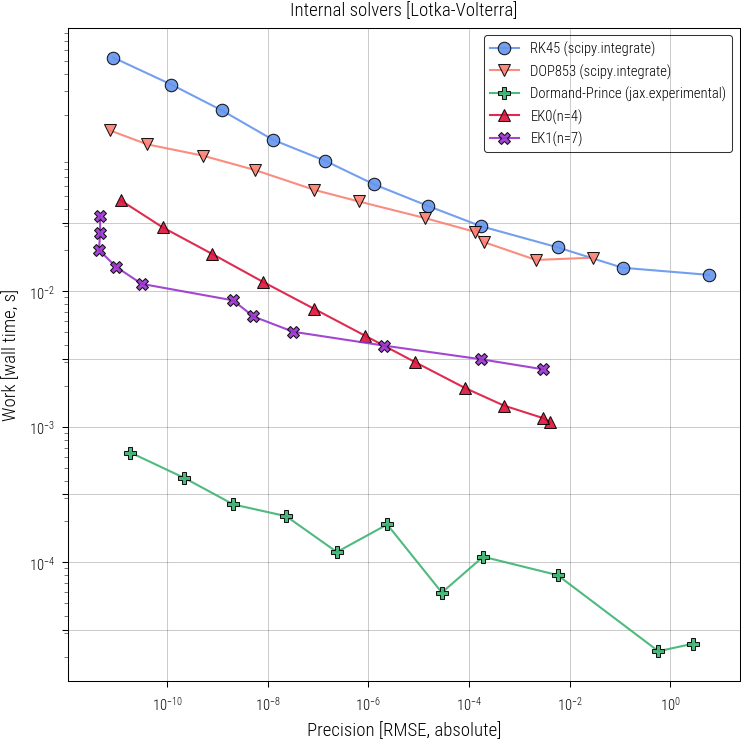

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))

for solver in results:
    times, errors = results[solver]
    ax.loglog(errors, times, label=solver, alpha=0.9)

ax.grid("both")
# ax.set_xticks(0.1 ** (jnp.arange(1.0, 12.0, step=1.0)))
ax.set_yticks(0.1 ** (jnp.arange(1.5, 5.0, step=0.5)))
ax.set_title(f"Internal solvers [{ODE_NAME}]")
ax.set_xlabel("Precision [RMSE, absolute]")
ax.set_ylabel("Work [wall time, s]")
ax.legend()
plt.show()